In [84]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# XGBoost 


In [85]:
import numpy as np
import pandas as pd
import xgboost as xgb

## Load Data and Create Features / Labels

In [86]:
df = pd.read_csv('../../data/raw/training.csv', index_col=0)
df.replace(-1, 999, inplace=True)

X = df.drop(['mobile_money','savings','borrowing','insurance','mobile_money_classification'], axis=1)
y = df['mobile_money_classification']

X.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8_1,Q8_2,Q8_3,...,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Latitude,Longitude
ID,,,,,,,,,,,,,,,,,,,,,
5086,98,2,3,1,1,2,2,0,0,0,...,2,999,2,999,1,999,4,4,-4.460442,29.811396
1258,40,1,1,3,5,1,1,1,0,0,...,1,4,1,5,4,4,1,4,-6.176438,39.244871
331,18,2,4,6,3,2,1,0,0,0,...,2,999,2,999,1,999,1,1,-6.825702,37.652798
6729,50,1,1,3,1,1,1,0,0,0,...,1,2,2,999,4,999,1,4,-3.372049,35.808307
8671,34,1,1,1,1,2,1,0,1,0,...,2,999,1,1,1,999,1,4,-7.179645,31.039095


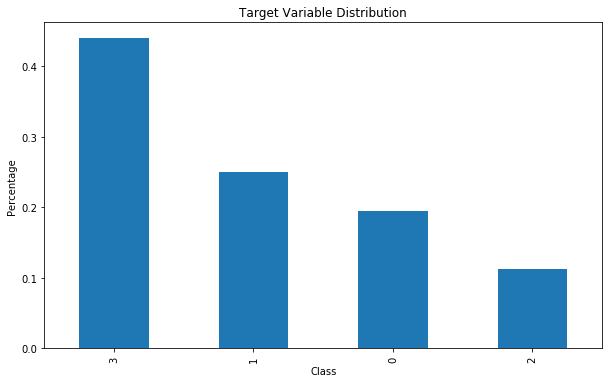

In [87]:
plot = y.value_counts(normalize=True).plot(kind='bar', title='Target Variable Distribution', figsize=(10,6))
plot.set_xlabel('Class')
plot.set_ylabel('Percentage');

## Create XBoost Model

In [88]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import log_loss
from xgboost.sklearn import XGBClassifier

seed = 2019

np.random.seed(seed)

def zindi_score(y_test, probs):
    """
    Score as we are being scored on LB
    """
    losses = []
    for c in [0,1,2,3]:
        labels = [1 if i == c else 0 for i in y_test]
        loss = log_loss(labels, probs[:, c])
        losses.append(loss)
    return sum(losses)

### Define Model and Starter Parameters

In [89]:
n_classes = y.nunique()

# Params that won't be changed
model_params = {
    'objective': 'multi:softprob', #multiclass classification, but output probabilities not classes
    'num_class': 4,
    'eval_metric': 'mlogloss',
    'seed': 2019
}

# Some default params to start with
starter_params = {
    'n_estimators': 500,
    'max_depth': 5,
    'gamma': 0,
    'min_child_weight': 1,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'scale_pos_weight': 1
}
# Combine parameters sets into one
xgb_params = {**model_params}
xgb_params.update(starter_params)

In [90]:
X.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8_1,Q8_2,Q8_3,...,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Latitude,Longitude
ID,,,,,,,,,,,,,,,,,,,,,
5086,98,2,3,1,1,2,2,0,0,0,...,2,999,2,999,1,999,4,4,-4.460442,29.811396
1258,40,1,1,3,5,1,1,1,0,0,...,1,4,1,5,4,4,1,4,-6.176438,39.244871
331,18,2,4,6,3,2,1,0,0,0,...,2,999,2,999,1,999,1,1,-6.825702,37.652798
6729,50,1,1,3,1,1,1,0,0,0,...,1,2,2,999,4,999,1,4,-3.372049,35.808307
8671,34,1,1,1,1,2,1,0,1,0,...,2,999,1,1,1,999,1,4,-7.179645,31.039095


## Create Modelling Function

In [148]:
def modelfit(alg, X, y ,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X, label=y)
        cvresult = xgb.cv(xgb_param, 
                          xgtrain, 
                          num_boost_round=alg.get_params()['n_estimators'], 
                          nfold=cv_folds,
                          metrics='mlogloss', 
                          early_stopping_rounds=early_stopping_rounds)
        
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X, y, eval_metric='mlogloss')
        
    #Predict training set:
    X_predictions = alg.predict(X)
    X_predprob = alg.predict_proba(X)
        
    #Print model report:
    print("\nModel Report")
    print("Log Loss : {:.4f}".format(log_loss(y, X_predprob))) 
    print("Zindi Score: {:.4f}".format(zindi_score(y, X_predprob)))
                    
    return alg, cvresult

### Test run with unprocessed features

In [130]:
model = XGBClassifier(**xgb_params)
model, cv_results = modelfit(model, X, y)


Model Report
Log Loss : 0.6791
Zindi Score: 1.2299


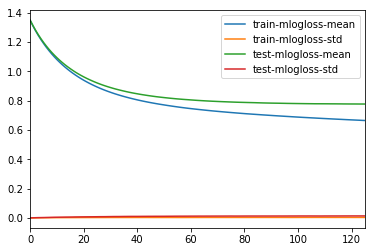

In [131]:
cv_results.plot()

Text(0, 0.5, 'Feature Importance Score')

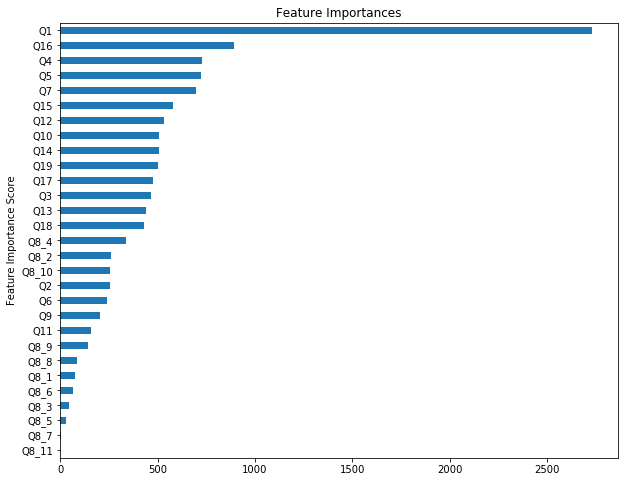

In [145]:
feat_imp = pd.Series(model.get_booster().get_score()).sort_values(ascending=True)
feat_imp.plot.barh(title='Feature Importances', figsize=(10,8))
plt.ylabel('Feature Importance Score')

## Make Prediction

In [159]:
from src.utils import make_sub

In [160]:
X_test = pd.read_csv('../../data/raw/test.csv', index_col=0)
X_test.replace(-1, 999, inplace=True)

test_probs = model.predict_proba(X_test)

sub_df = make_sub(test_probs)

sub_df.head()

,no_financial_services,other_only,mm_only,mm_plus
2352,0.002002,0.002208,0.226802,0.768988
8208,0.017585,0.023452,0.104422,0.854541
2785,0.002690,0.006718,0.116565,0.874026
2967,0.394234,0.522412,0.017102,0.066252
1697,0.001625,0.002482,0.095563,0.900330


In [162]:
sub_df.to_csv('../../data/submissions/xgb_baseline.csv')